### Tutorial: Graph Signal Visualization and Graph Anomaly Generation Functions

- `src.util.generate_anomaly` contains the anomaly generation functions
- `src.util.gsp_vis` contains the anomaly visualization package

In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import project_path
from src.util.graph import *
from src.util.generate_anomaly import generate_sparse_anomaly, generate_local_anomaly, generate_temporal_anomaly, generate_spatio_temporal_anomaly
from src.util.gsp_vis import draw_graph_signal, GraphSignalAnimation

In [2]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

We have 4 functions to generate anomalies:
1. `generate_sparse_anomaly`: The anomalies are independent from each other
2. `generate_local_anomaly`: The generated anomalies are a collection of locally contiguous packets over the graph.
3. `generate_temporal_anomaly`: The generated anomalies are a collection of temporally contiguous packets over time with specific duration.
4. `generate_spatio_temporal_anomaly`: The generated anomalies are a collection of temporally and locally contiguous packets over the graph.


Let's start with generating a 2D cartesian grid graph and an anomalous graph signal and visualize it.

`GraphProcess` class is unimportant for our purpose. I use it to generate random smooth signals over a graph structure. It uses `networkx` package and graphs.

- `draw_graph_signal` is a function that I use to draw a graph signal (in vector form). 
- `GraphSignalAnimation` is a class I use to animate sequential graph signals (in matrix form where columns are signals)

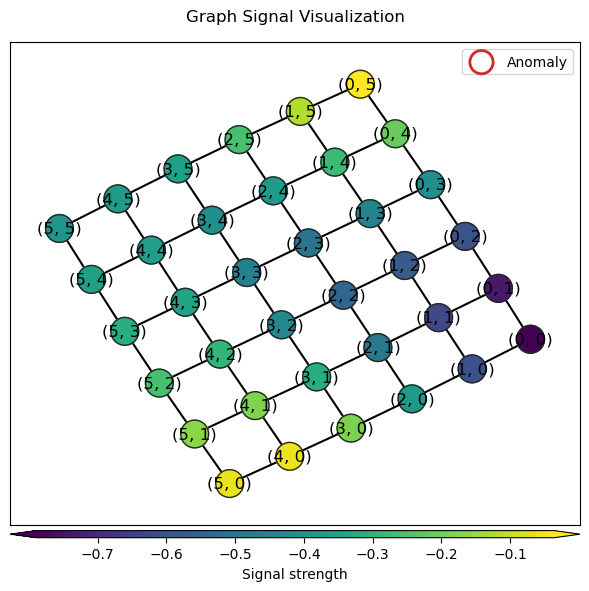

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

In [14]:
G = nx.grid_2d_graph(6,6)
GP = GraphProcess(G=G, seed=100, filter_type='Heat', filter_parameters=10)
x = GP.gen_signal(1,0,0)
x = x['X']
draw_graph_signal(G, x, figsize=(6,6))

### Let's generate sparse anomalies now and visualize them.
`generate_sparse_anomaly` takes a signal `x` (a tensor with arbitrary dimensions) and returns an `anomaly` tensor along with a boolean `anomaly_labels` tensor with the same dimensions that take `True` value where the `anomaly` tensor is nonzero.

`anomaly_labels` can be used with `draw_graph_signal` to indicate that those entries are anomalous.

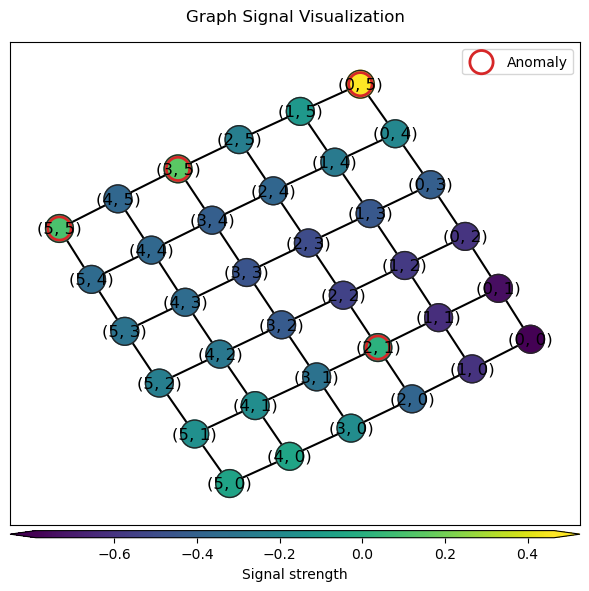

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

In [16]:
anomaly, anomaly_labels = generate_sparse_anomaly(x,'constant', amp=0.5, num_of_anomalies=4)
Y = x+anomaly
# Y = anomaly
draw_graph_signal(G, Y, anomaly_labels=anomaly_labels, figsize=(6,6))

### Let's now generate local anomaly packets with `generate_local_anomaly` and visualize them.

Similar to before we have to give the signal `x` to the function with the graph `G` along with some other parameters.

The function `generate_local_anomaly` works with any dimensional data. So it assumes the signal is a tensor. You have to specify which mode of the tensor is the local mode otherwise it will assume it's the first mode (the columns if it is a matrix).

In this case we are giving it a vector because we only generated 1 signal. 

- `radius` parameter controls how spread out the anomaly packets are locally. 
- `anomaly_type` controls how the distribution is done. I only used 'constant' option for now. You can use 'diffuse' too.
- `num_of_anomalies` parameter controls how many anomaly packets are generated like this.

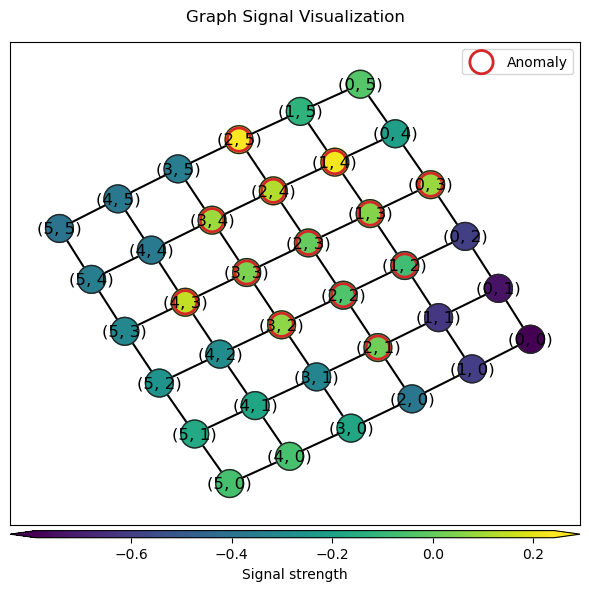

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

In [20]:
anomaly, anomaly_labels = generate_local_anomaly(x, G, anomaly_type='constant', amp=0.5, local_mode=1,
                                                radius=2, num_of_anomalies=1)
Y = x+anomaly
# Y = anomaly
draw_graph_signal(G, Y, anomaly_labels=anomaly_labels, figsize=(6,6))

### Let's insert local anomalies to a sequential graph signal and animate it

`GraphSignalAnimation` is a class instance that I use to use matplotlib's animation capabilities. It assumes that the signal is in matrix form and the second mode (the rows) is the temporal mode.

In [28]:
x = GP.gen_signal(20,0,0)
x = x['X']

anomaly, anomaly_labels = generate_local_anomaly(x, G, anomaly_type='constant', amp=0.8, local_mode=1,
                                                radius=1, num_of_anomalies=8)
Y = x+anomaly

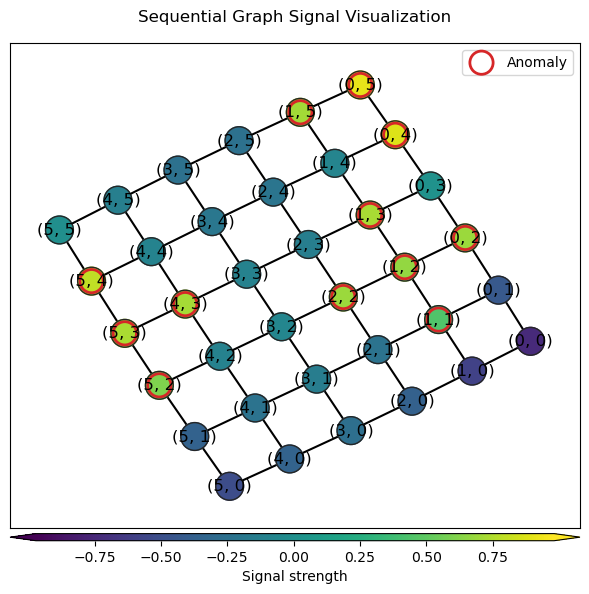

In [31]:
GSPAnimation = GraphSignalAnimation(G,Y, anomaly_labels=anomaly_labels, figsize=(6,6))
anim = FuncAnimation(GSPAnimation.fig, GSPAnimation,frames=20, interval=400, blit=True);
HTML(anim.to_jshtml())

### Let's make the anomalies temporally contiguous too
For that, you can use `generate_spatio_temporal_anomaly`.This function wants,
1. The dimensions of the signal so (I call it with `x.shape` this time)
2. The graph `G`
3. you to specify which mode is temporal and which mode is local.
4. wants a `window_type` (a window function to apply the anomalies temporally) It's default is `'boxcar'` which is the rectangular window. You can use triangular, hamming or whichever window that `scipy.signal.windows` allow you to.
5. `duration` the temporal duration of the anomaly packets.

In this case we have to also specify the temporal or sequential mode of the tensor. Otherwise it will assume it's the second mode (the rows for a matrix).

In [38]:
x = GP.gen_signal(20,0,0)
x = x['X']

anomaly, anomaly_labels = generate_spatio_temporal_anomaly(x.shape, G, num_anomalies=8,
                                                            distribution='constant', amplitude=0.8,
                                                        local_m=1, time_m=2, window_type='boxcar',
                                                radius=1, duration=4)
Y = x+anomaly

In [24]:
G = nx.random_geometric_graph(20,0.3, seed=100)
GP = GraphProcess(G=G, seed=100, filter_type='Heat', filter_parameters=10)
x = GP.gen_signal(10,0,0)
X = x['X']
# anomaly, anomaly_labels = generate_local_anomaly(X,G, 'constant', 1, local_mode=1, num_of_anomalies=5, radius=1)
# anomaly, anomaly_labels = generate_sparse_anomaly(X,'constant', 1, num_of_anomalies=1)
anomaly, anomaly_labels = generate_temporal_anomaly(X, amplitude=1, 
                            num_of_anomalies=4, anomaly_duration=4,
                            window_type='boxcar', distribution='constant',
                            temporal_mode=2, seed=None)
Y = anomaly


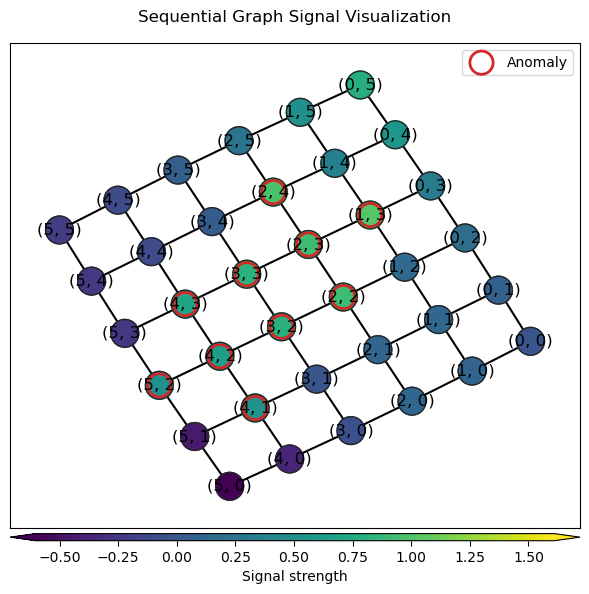

In [39]:
GSPAnimation = GraphSignalAnimation(G,Y, anomaly_labels=anomaly_labels, figsize=(6,6))
anim = FuncAnimation(GSPAnimation.fig, GSPAnimation,frames=20, interval=400, blit=True);
HTML(anim.to_jshtml())